In [1]:
import pandas as pd
import numpy as np
import healpy as hp

from astropy.cosmology import Planck15
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys

H0GLOB=67.9 #69
Om0GLOB=0.3
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s


/home/rciancarella/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
        Use get instead. [ligo.skymap.postprocess.cosmology]


In [2]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        print('Theta={}, Phi={}'.format(theta, phi))
        ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        dl=metadata['distmean']
        std=metadata['diststd']
        z=cosmoglob.H(0).value*dl/clight
        sigz=cosmoglob.H(0).value*std/clight
        print('dL={}Mpc, std={}Mpc'.format(dl,std))
        print('z={}, delta_z={}'.format(z,sigz))
        print('\n')
        head = None

In [3]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
#os.listdir()

  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [4]:
#Some files to look at 
filenames=['GW190412_PublicationSamples.fits','GW190814_PublicationSamples.fits',
          'GW190924_021846_PublicationSamples.fits','GW190527_092055_PublicationSamples.fits',
         'GW190421_213856_PublicationSamples.fits','GW190708_232457_PublicationSamples.fits',
         'GW190915_235702_PublicationSamples.fits']
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190924_021846_PublicationSamples.fits'
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)

In [5]:
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)
theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
#10 deg^2 =0.000 304 617 419 786 71 sr
radius_deg= np.sqrt(10/np.pi)
sigma_deg=radius_deg/2.8
circle_deg=6*sigma_deg

In [6]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

296831 296831


In [7]:
print(vec)

[-0.5812998   0.76401552  0.27994792]


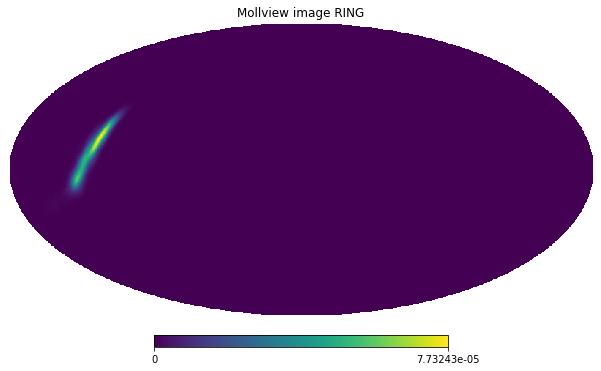

In [8]:
hp.mollview(p_posterior, title="Mollview image RING",nest=True)

In [9]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print(Ligo_Area_deg)

377.57722863937363


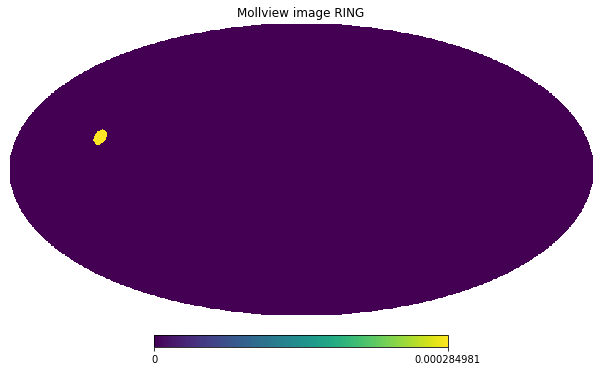

In [13]:
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Mollview image RING",nest=True)

In [15]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

99.9999% area is 46.01689689134351 squared deg
90% area is 10.00595392650188 squared deg


In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


In [25]:
saved_prob=np.zeros(len(p_posterior))
saved_prob[ipix_disc]=p_posterior[ipix_disc]
prob_to_write=np.zeros(len(p_posterior))
alpha=1/np.sum(saved_prob)
prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [26]:
print(np.sum(prob_to_write))

0.9999999999999998


-0.8225290387762384
